In [14]:
required_packages <- c(
"caret",
"MASS",
"randomForest",
"e1071",
"ggplot2",
"dplyr",
"corrplot",
"nnet",
"naivebayes",
"MVN",
"mgcv",
"devtools"
)

# Function to install and load packages
install_and_load_packages <- function(packages) {
  cat("Checking and installing required packages...\n")
  
  for (package in packages) {
    if (!require(package, character.only = TRUE, quietly = TRUE)) {
      cat(sprintf("Installing package: %s\n", package))
      install.packages(package, dependencies = TRUE)
      if (!require(package, character.only = TRUE, quietly = TRUE)) {
        stop(sprintf("Package '%s' installation failed", package))
      }
    } else {
      cat(sprintf("Package '%s' is already installed and loaded\n", package))
    }
  }
  cat("\nAll required packages are installed and loaded!\n\n")
}

# Install and load all required packages
install_and_load_packages(required_packages)


Checking and installing required packages...
Package 'caret' is already installed and loaded
Package 'MASS' is already installed and loaded
Package 'randomForest' is already installed and loaded
Package 'e1071' is already installed and loaded
Package 'ggplot2' is already installed and loaded
Package 'dplyr' is already installed and loaded
Package 'corrplot' is already installed and loaded
Package 'nnet' is already installed and loaded
Package 'naivebayes' is already installed and loaded
Package 'MVN' is already installed and loaded
Package 'mgcv' is already installed and loaded
Package 'devtools' is already installed and loaded

All required packages are installed and loaded!



In [15]:
if (!requireNamespace("UBL", quietly = TRUE)) {
    devtools::install_github("paobranco/UBL")
} else {
    cat("Package 'UBL' is already installed.\n")
}

Package 'UBL' is already installed.


In [16]:
library(caret)
library(MASS)
library(randomForest)
library(naivebayes)
library(e1071)
library(ggplot2)
library(dplyr)
library(corrplot)
library(nnet)
library(MVN)
library(mgcv)
library(DMwR)
library(UBL)
library(devtools)

In [17]:
# Read the data
data <- read.table("a24_clas_app.txt", header = TRUE, sep=" ")

# Convert y to a factor
data$y <- as.factor(data$y)

# Make a copy of the original data for processing
data_cleaned <- data
data_cleaned_2 <- data

# Identify excluded variables (0-13 values)
excluded_vars <- c("X46", "X47", "X48", "X49", "X50") 
numeric_vars <- names(data_cleaned)[sapply(data_cleaned, is.numeric) & !(names(data_cleaned) %in% excluded_vars) & names(data_cleaned) != "y"]

# Outlier Removal
# ------------------
# Calculate skewness and IQR filtering for outliers on selected numeric variables only
for (var in numeric_vars) {
  Q1 <- quantile(data_cleaned[[var]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data_cleaned[[var]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  
  lower_bound <- Q1 - 1.5 * IQR_val
  upper_bound <- Q3 + 1.5 * IQR_val
  
  # Remove rows with outliers in any numeric variable
  data_cleaned <- data_cleaned[!(data_cleaned[[var]] < lower_bound | data_cleaned[[var]] > upper_bound), ]
}

# Calculate the ratio of rows deleted
cat("Rows deleted due to outliers:", (1 - nrow(data_cleaned) / nrow(data)) * 100, "%\n")

# Scaling
# ----------
# Apply scaling to numeric variables only
preprocess_params <- preProcess(data_cleaned[, numeric_vars], method = c("center", "scale"))
data_scaled <- data_cleaned
data_scaled[, numeric_vars] <- predict(preprocess_params, data_cleaned[, numeric_vars])

preprocess_params_2 <- preProcess(data_cleaned_2[, numeric_vars], method = c("center", "scale"))
data_scaled_2 <- data_cleaned_2
data_scaled_2[, numeric_vars] <- predict(preprocess_params_2, data_cleaned_2[, numeric_vars])

# Separate datasets with and without excluded variables
data_outlier <- data_scaled
data_outlier_excluded <- data_scaled %>% select(-all_of(excluded_vars))
data <- data_scaled_2
data_excluded <- data_scaled_2 %>% select(-all_of(excluded_vars))

Rows deleted due to outliers: 27.6 %


# weights:  156 (102 variable)
initial  value 194.454375 
iter  10 value 117.648488
iter  20 value 74.078052
iter  30 value 62.224080
iter  40 value 53.691678
iter  50 value 49.762271
iter  60 value 48.147074
iter  70 value 46.937359
iter  80 value 46.584401
iter  90 value 46.534242
final  value 46.534167 
converged
# weights:  156 (102 variable)
initial  value 194.454375 
iter  10 value 120.410160
iter  20 value 85.740950
iter  30 value 81.420848
iter  40 value 80.569136
iter  50 value 80.424369
iter  60 value 80.404337
iter  70 value 80.401238
final  value 80.401146 
converged
# weights:  156 (102 variable)
initial  value 194.454375 
iter  10 value 117.651414
iter  20 value 74.093743
iter  30 value 62.261856
iter  40 value 53.787285
iter  50 value 49.961032
iter  60 value 48.445810
iter  70 value 47.495527
iter  80 value 47.336974
iter  90 value 47.277310
iter 100 value 47.238507
final  value 47.238507 
stopped after 100 iterations
# weights:  156 (102 variable)
initial  value 195.55

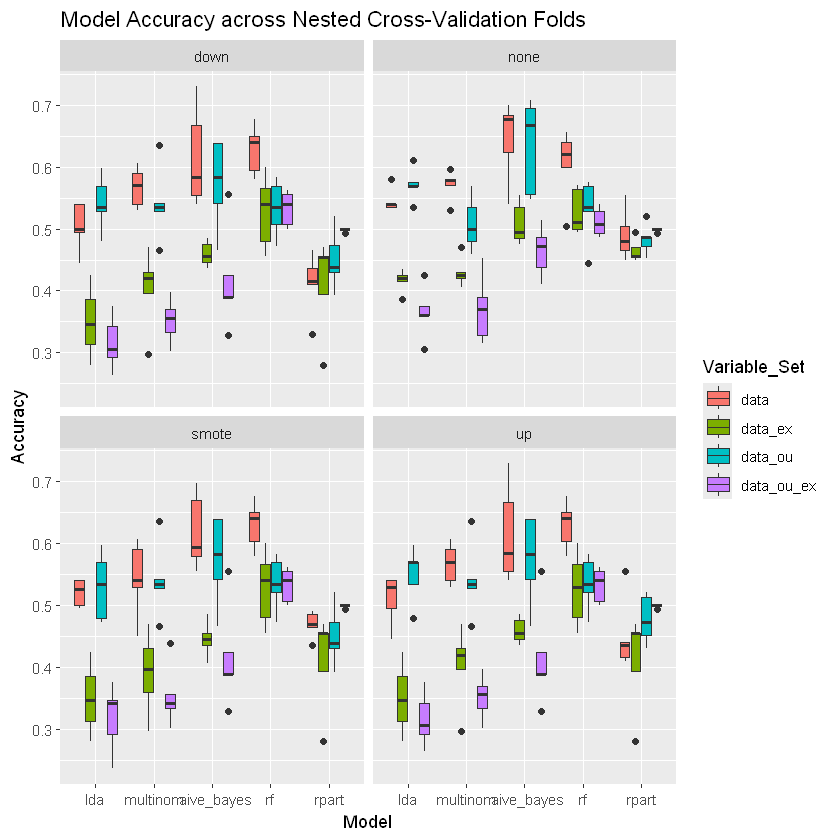

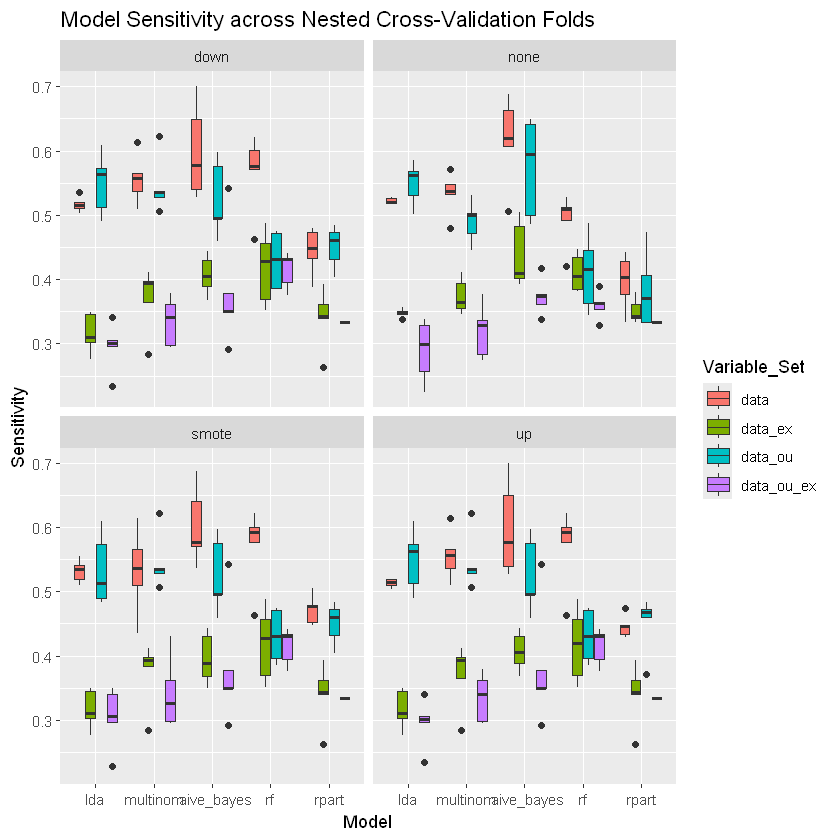

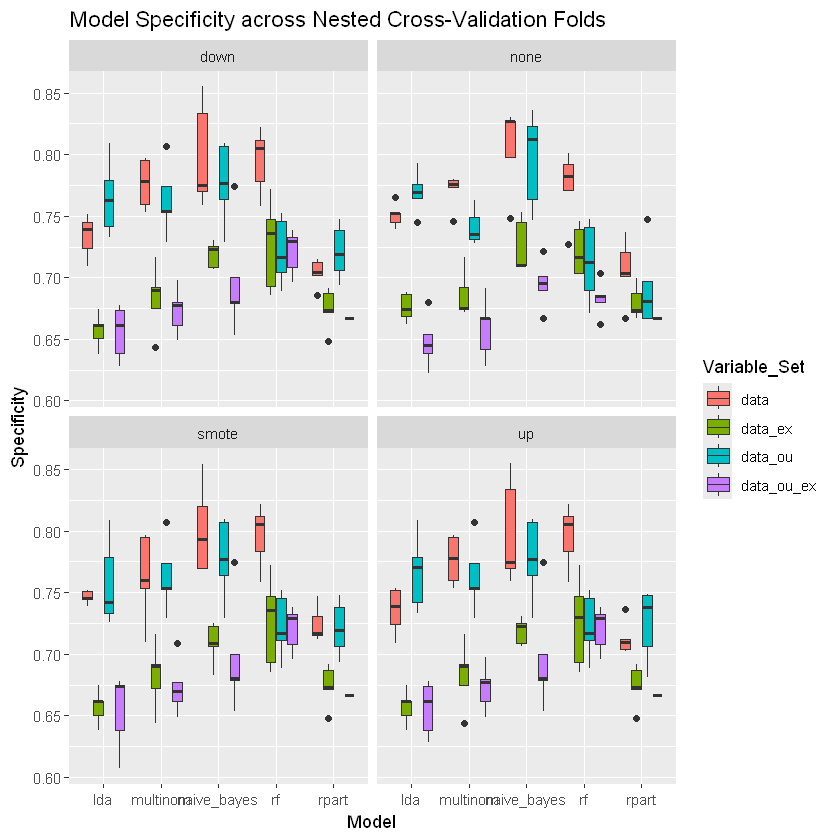

In [18]:
# Define outer and inner folds
outer_folds <- 5
inner_folds <- 3

classification_methods <- c("multinom", "naive_bayes", "lda", "rpart", "rf")

evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)
  
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  
  return(list(
    Accuracy = metrics["Accuracy"],
    Sensitivity = metrics["Mean_Sensitivity"],
    Specificity = metrics["Mean_Specificity"]
  ))
}

# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

sampling_methods <- c("none", "up", "down", "smote") # Add your sampling methods here

results <- data.frame(Model = character(), Variable_Set = character(), Sampling_Method = character(), Fold = integer(),
                      Accuracy = numeric(), Sensitivity = numeric(), Specificity = numeric(), F1 = numeric(), row.names = NULL)

for (method in classification_methods) {
  for (variable_set in c("data", "data_ex", "data_ou", "data_ou_ex")) {
    
    data_set <- switch(variable_set,
                       "data" = data,
                       "data_ex" = data_excluded,
                       "data_ou" = data_outlier,
                       "data_ou_ex" = data_outlier_excluded)
    
    for (outer_fold in 1:outer_folds) {
      outer_train_index <- createFolds(data_set$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
      outer_train_data <- data_set[outer_train_index, ]
      outer_test_data <- data_set[-outer_train_index, ]
      
      best_inner_model <- NULL
      best_inner_accuracy <- 0
      
      for (sampling_method in sampling_methods) {
        sampled_outer_train_data <- sample_data(outer_train_data, method = sampling_method)
        
        for (inner_fold in 1:inner_folds) {
          inner_train_index <- createFolds(sampled_outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
          inner_train_data <- sampled_outer_train_data[inner_train_index, ]
          inner_val_data <- sampled_outer_train_data[-inner_train_index, ]
          
          model <- train(y ~ ., data = inner_train_data, method = method, trControl = trainControl(method = "cv", number = inner_folds), metric = "Accuracy")
          
          val_pred <- predict(model, newdata = inner_val_data)
          val_accuracy <- mean(val_pred == inner_val_data$y)
          
          if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- model
            best_inner_accuracy <- val_accuracy
          }
        }
        
        outer_metrics <- evaluate_model(best_inner_model, outer_test_data, outer_test_data$y)
        
        results <- rbind(results, data.frame(Model = method, Variable_Set = variable_set, Sampling_Method = sampling_method, Fold = outer_fold,
                                             Accuracy = outer_metrics$Accuracy,
                                             Sensitivity = outer_metrics$Sensitivity,
                                             Specificity = outer_metrics$Specificity, row.names = NULL))
      }
    }
  }
}

# Plot results
ggplot(results, aes(x = Model, y = Accuracy, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Accuracy across Nested Cross-Validation Folds",
       x = "Model", y = "Accuracy")

ggplot(results, aes(x = Model, y = Sensitivity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Sensitivity across Nested Cross-Validation Folds",
       x = "Model", y = "Sensitivity")

ggplot(results, aes(x = Model, y = Specificity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Specificity across Nested Cross-Validation Folds",
       x = "Model", y = "Specificity")


In [19]:
results %>% arrange(desc(Accuracy))

Model,Variable_Set,Sampling_Method,Fold,Accuracy,Sensitivity,Specificity
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
naive_bayes,data,up,5,0.7300000,0.6999428,0.8551374
naive_bayes,data,down,5,0.7300000,0.6999428,0.8551374
naive_bayes,data_ou,none,1,0.7083333,0.6496965,0.8360365
naive_bayes,data,none,5,0.7000000,0.6630912,0.8301900
naive_bayes,data,smote,3,0.6969697,0.6874513,0.8543134
naive_bayes,data_ou,none,5,0.6944444,0.6411185,0.8230172
naive_bayes,data,none,2,0.6831683,0.6881590,0.8270803
naive_bayes,data,none,3,0.6767677,0.6189327,0.8268069
rf,data,up,2,0.6767677,0.6216618,0.8217216


until here we good

In [ ]:
# Fit the GAM model
data_gam <- data
data_gam[, excluded_vars] <- lapply(data_gam[, excluded_vars], as.factor)
preprocess_params_gam <- preProcess(data_gam[, numeric_vars], method = c("center", "scale"))
data_scaled_gam <- data_gam
data_scaled_gam[, numeric_vars] <- predict(preprocess_params_gam, data_gam[, numeric_vars])
print(head(data_scaled_gam))
continuous_vars <- paste0("s(X", 1:45, ")", collapse = " + ")
categorical_vars <- paste0("X", 46:50, collapse = " + ")
formula_string <- paste("y ~", continuous_vars, "+", categorical_vars)
model_formula <- as.formula(formula_string)
print(model_formula)

          X1           X2         X3         X4          X5         X6
1  0.1520951 -0.001077043  1.3232418  0.4829507  1.18447294  0.3128938
2  1.4828231 -1.320965483  0.8605130 -1.5410116 -1.19194583  1.0559602
3  1.6973454  1.575098487 -0.9227483  0.8383256 -0.71254470 -0.2796727
4 -1.1266522  1.213395380 -1.6323412  1.3704219 -0.77110979  0.5366186
5  0.7427705  0.319138772 -1.4308311 -0.7153544 -1.43298490 -1.2511355
6  1.0272638 -1.549598214 -1.3811201 -0.1612517  0.06608898  0.3763517
          X7         X8         X9        X10         X11        X12
1 -1.0309908 -1.1270022  1.0249860  1.4966017  0.11115773  0.8332604
2 -0.9621786  1.0931273  1.2423460 -0.2570111  0.12281814  0.4889229
3 -0.9251125 -0.5612810 -0.8580621  0.6826289 -1.20773705 -0.8165060
4  1.6303239  0.4889026  0.4843326 -1.2531756  0.80254853  1.2836441
5 -0.3360766  0.1892026  1.5472019  0.4840599 -0.03292476 -1.1545984
6  0.7836426  0.3381814 -0.3515586 -0.3020698 -0.33811617  0.8372291
          X13       

In [ ]:
# Define outer and inner folds
outer_folds <- 5
inner_folds <- 3

evaluate_gam_model <- function(model, test_data, true_labels) {
    predictions <- predict(model, newdata = test_data, type = "response")
    predicted_classes <- apply(predictions, 1, which.max)
    levels <- levels(true_labels)
    predicted_classes <- levels[predicted_classes]
    
    accuracy <- mean(predicted_classes == true_labels)
    return(accuracy)
}

results_gam <- data.frame(Fold = integer(), Accuracy = numeric(), row.names = NULL)

for (outer_fold in 1:outer_folds) {
    outer_train_index <- createFolds(data_scaled_gam$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
    outer_train_data <- data_scaled_gam[outer_train_index, ]
    outer_test_data <- data_scaled_gam[-outer_train_index, ]
    
    best_inner_model <- NULL
    best_inner_accuracy <- 0
    
    for (inner_fold in 1:inner_folds) {
        inner_train_index <- createFolds(outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
        inner_train_data <- outer_train_data[inner_train_index, ]
        inner_val_data <- outer_train_data[-inner_train_index, ]
        
        gam_model <- gam(model_formula, family = multinom(K = 3), data = inner_train_data)
        
        val_accuracy <- evaluate_gam_model(gam_model, inner_val_data, inner_val_data$y)
        
        if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- gam_model
            best_inner_accuracy <- val_accuracy
        }
    }
    
    outer_accuracy <- evaluate_gam_model(best_inner_model, outer_test_data, outer_test_data$y)
    
    results_gam <- rbind(results_gam, data.frame(Fold = outer_fold, Accuracy = outer_accuracy, row.names = NULL))
}

row.names(results_gam) <- NULL


# Plot results
ggplot(results_gam, aes(x = factor(Fold), y = Accuracy)) +
    geom_boxplot() +
    labs(title = "GAM Model Accuracy across Nested Cross-Validation Folds",
         x = "Fold", y = "Accuracy")


ERROR: Error in offset[[i]]: tentative de sélection de moins d'un élément dans integerOneIndex
